<a href="https://colab.research.google.com/github/kamranuz/mmdm2024-lab-1/blob/master/HSE_MMDM_2024_Lab_%E2%84%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HSE MMDM 2024 | Lab Work №1


### -- Rules --
- Grade = 0.3*Task1 + 0.3*Task2 + 0.4*Task3
- You can work in small groups: 1-3 students.
- Correct but basic solution of each task costs 8 points. To get 9, 10 be creative: think of some modification for basic algorithms; cool visualisation may also give you additional points
- Write your own code for algorithms!
- Deadline - 01.04.2024



### -- Team --

[Mike](https://t.me/MC_Mikel) &
[Вацлав](https://t.me/RinokuS) &
[Kamrаn](https://t.me/kamran_uz)


### -- Tickets --
| Title | Explanation | Responsible Person |[x]|
| --- | --- | --- |--- |
| Preparation | Prepare space/material and etc for team work | Kamron | [x]|
| Preparation | ~~Create base classes for solutions~~ | ~~Вацлав~~ |[x]|
| Task 1 | Implement baseline-solution using special libraries | Вацлав |[x]|
| Task 1 | Implement GA algorithm solution | Kamron |[x]|
| Task 1 | Make comprehensive analysis of the implementations | Mike |[x]|
| Task 1 | Create comprehensive visualizations | Вацлав, Kamron |[x]|
| Task 2 | Implement baseline-solution using special libraries | Kamron |[x]|
| Task 2 | Implement NSGA II algorithm solution | Mike |[x]|
| Task 2 | Make comprehensive analysis of the implementations | Вацлав |[x]|
| Task 2 | Create comprehensive visualizations | Mike |[x]|
| Task 3 | Solve it | Kamron |[x]|
| Post solution | Conclusions | Mike, Kamron, Вацлав|[x]|
| Post solution | Submission | Kamron |[x]|

In [27]:
# @title import libraries
import math
import random
import sys
from itertools import product
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.manifold import MDS

!pip install pulp
import pulp

!pip install deap
from deap import base, creator, tools, algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.9 MB/s eta 0:00:00


## Task 1
Use genetic algorithm to find global extremum of given functions. Make sure your algorithm works for n dimensional objective functions.

(a)
$$
\max_{x,y} f(x, y)
=
3(1-x)^2
\exp\left(-x^2-(y+1)^2\right)
-
10\left(\frac{x}{5} - x^3 - y^5\right)
\exp\left(-x^2-y^2\right)
-
\frac{1}{3} \exp\left(-(x+1)^2-y^2\right)
$$
(b)

$$
\min_{x,y} f(x, y)
=
-0.0001
\left(
    \left\lvert
        \sin(x)
        \sin(y)
        \exp\left(\left|
            100 - \frac{\sqrt{x^2 + y^2}}{\pi}
            \right|\right)
    \right\rvert
    +
    1
\right)^{0.1}
\quad
(x, y) \in [-10, 10]^2
$$

### Solution using libraries

In [223]:
#@title def logic

f_a = lambda x, y: 3*(1-x)**2 * np.exp(-x**2-(y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2-y**2) - 1/3 * np.exp(-(x+1)**2-y**2)
f_b = lambda x, y: -0.0001 * (abs(np.sin(x) * np.sin(y) * np.exp(abs(100 - np.sqrt(x**2 + y**2)/np.pi)) + 1)**0.1)
f_a.__name__ = 'f_a'
f_b.__name__ = 'f_b'

def evaluate_a(individual):
    x, y = individual
    return f_a(x, y),

def evaluate_b(individual):
    x, y = individual
    return f_b(x, y),

def perform_genetic_algorithm(evaluate_function, handler="maximization", generations=100, size=100, verbose=False):
    weights = (1.0,) if handler == "maximization" else (-1.0,)

    try:
        del creator.Fitness
        del creator.Individual
    except Exception as e:
        pass

    creator.create("Fitness", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, -100, 100)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_function)

    population = toolbox.population(n=size)
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=200, cxpb=0.6, mutpb=0.3, ngen=generations, verbose=verbose)

    # Get the best individual and its fitness value
    best_ind = tools.selBest(population, 1)[0]
    best_value = evaluate_function(best_ind)

    return best_ind, best_value

In [224]:
#@title result

individual_a, value_a = perform_genetic_algorithm(evaluate_a)
print(f"For function f_a DEAP algo found best individual '{individual_a}' with function value '{value_a}'")

individual_b, value_b = perform_genetic_algorithm(evaluate_b, handler="minimization")
print(f"For function f_b DEAP algo found best individual '{individual_b}' with function value '{value_b}'")

For function f_a DEAP algo found best individual '[-0.009317576517067121, 1.581367964739772]' with function value '(8.10621358944234,)'
For function f_b DEAP algo found best individual '[1.3494065894146856, 1.3494066003293765]' with function value '(-2.0626118708227397,)'


### Solution without libraries

In [238]:
#@title def logic

def generate_population(size=100, min_value=-10,max_value=10):
    population = np.random.random((size,2))*2*max_value+min_value
    return population

def crossover(population, add_size=100):
    popultaion_pairs_sample_id =  np.random.choice(range(len(population)),(add_size,2))
    next_population = [(population[id_f]+population[id_m])/2 for id_f, id_m in popultaion_pairs_sample_id]
    next_population = np.concatenate((next_population,population))
    return next_population

def swap_random_genes(organism):
    return organism*(1+np.random.choice([1,-1])*np.random.random()/3)

def mutate(population, add_size=100):
    next_population = []
    popultaion_sample_id =  np.random.choice(range(len(population)),add_size)
    next_population = [swap_random_genes(population[organism_id]) for organism_id in popultaion_sample_id]
    next_population = np.concatenate((next_population,population))
    return next_population


def f_fitness(organism, f):
    # print(organism)
    fit_num = f(*organism)
    return fit_num

def selection(population, f, size=100):
    selection_propabilty_temp = np.array([f_fitness(organism, f) for organism in population])

    selection_propabilty_temp = max(selection_propabilty_temp)-selection_propabilty_temp
    selection_propabilty      = selection_propabilty_temp/sum(selection_propabilty_temp)

    population_id = range(len(population))
    selected_population_id = np.random.choice(population_id,size,replace=False,p=selection_propabilty)
    selected_population = np.array(population)[selected_population_id]
    selected_population = list(selected_population)
    return selected_population

def genetic_algorithm(f, generations=100, size=100, crossover_size=100, mutate_size=10):
    log = {
        'generation':[],
        'min': [],
        'mean': [],
        'max': [],
        'population': []
    }
    population = generate_population(size=size)
    for i in tqdm(range(generations)):
        selection_propabilty_temp = np.array([f_fitness(organism, f) for organism in population])
        log['generation'] += [i]
        log['min']        += [min(selection_propabilty_temp)]
        log['mean']       += [np.mean(selection_propabilty_temp)]
        log['max']        += [max(selection_propabilty_temp)]
        log['population'] += [population]

        population = mutate(population, add_size=mutate_size)
        # print(population)
        population = crossover(population, add_size=crossover_size)
        population = selection(population, f, size=size)
    return log, population

In [263]:
#@title result
log, population = genetic_algorithm(lambda x,y: -f_a(x,y),generations=200, size=400, crossover_size=200, mutate_size=100)
value_a,individual_a = max([(f_a(*i),i) for i in population])
print()
print(f"For function f_a our algo found best individual '{individual_a}' with function value '{value_a}'")

log, population = genetic_algorithm(lambda x,y: f_b(x,y),generations=200, size=400, crossover_size=200, mutate_size=100)
value_b,individual_b = min([(f_b(*i),i) for i in population])
print()
print(f"For function f_b our algo found best individual '{individual_b}' with function value '{value_b}'")

100%|██████████| 200/200 [00:02<00:00, 68.56it/s]



For function f_a our algo found best individual '[0.04074221 1.58209085]' with function value '8.085936137902088'


100%|██████████| 200/200 [00:03<00:00, 62.14it/s]


For function f_b our algo found best individual '[1.4368196  1.25359417]' with function value '-2.060494554762557'


### Visualization

In [49]:
# @title def create_surface_plot
def create_surface_plot(f, x_range=(-10, 10), y_range=(-10, 10), point_marker=None, point_color='green'):
    x, y = np.linspace(*x_range, 100), np.linspace(*y_range, 100)
    x, y = np.meshgrid(x, y)

    z = f(x, y)

    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

    if point_marker:
        point_x, point_y = point_marker
        fig.add_trace(go.Scatter3d(x=[point_x], y=[point_y], z=[f(point_x, point_y)],
                                   mode='markers', marker=dict(size=5, color=point_color), name='Point'))

    fig.update_layout(title=f'Surface Plot for {f.__name__}', autosize=True)
    fig.show()

In [50]:
# @title Plotting f_b
create_surface_plot(f_a, point_marker=individual_a)

In [211]:
# @title Plotting f_b
create_surface_plot(f_b, point_marker=individual_b)

## Task 2

Find pareto front for the given multi-objective optimisation problem using NSGA II algorithm. Take n = 3, but you may try other values as well.
$$
\min_{x} = \begin{cases}
    f_1(x)
    =
    1
    -
    \exp\left(
        -\sum_{i=1}^{n}
            \left(
                x_i - \sqrt{\frac{1}{n}}
            \right)^2
        \right) \\
    f_2(x)
    =
    1
    -
    \exp\left(
        -\sum_{i=1}^{n}
            \left(
                x_i + \sqrt{\frac{1}{n}}
            \right)^2
        \right)
\end{cases}
\quad
-4 \leq x_i \leq 4, \quad 1 \leq i \leq n
$$


### Solution using libraries

In [52]:
# @title def logic

# Problem definition
n_var = 3
bounds = [(-4, 4)] * n_var
n_gen = 250
pop_size = 100

# Objective functions
def f1(x):
    return 1 - np.exp(-np.sum((x - 1/np.sqrt(len(x)))**2))

def f2(x):
    return 1 - np.exp(-np.sum((x + 1/np.sqrt(len(x)))**2))

# DEAP framework setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -4, 4)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_var)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: (f1(ind), f2(ind)))
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=-4, up=4, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=-4, up=4, eta=20.0, indpb=1.0/n_var)
toolbox.register("select", tools.selNSGA2)

# Evolutionary process
random.seed(1)
pop = toolbox.population(n=pop_size)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning:

A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning:

A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.



In [53]:
# @title result
result = algorithms.eaMuPlusLambda(pop, toolbox, mu=pop_size, lambda_=pop_size, cxpb=0.7, mutpb=0.3, ngen=n_gen, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg                    	std                    	min                    	max    
0  	100   	[0.99177326 0.98827146]	[0.07053919 0.05511522]	[0.2918239  0.61686625]	[1. 1.]
1  	100   	[0.96618772 0.97178378]	[0.1387797  0.09511608]	[0.2918239  0.47684549]	[1. 1.]
2  	100   	[0.92701738 0.95196344]	[0.19613108 0.11690323]	[0.17357376 0.42206551]	[1.         0.99999998]
3  	100   	[0.86559524 0.90305748]	[0.2454939  0.16930221]	[0.17357376 0.09570018]	[0.99999798 0.99995318]
4  	100   	[0.78905151 0.82651928]	[0.27948808 0.2349173 ]	[0.17357376 0.09553559]	[0.99922224 0.99971798]
5  	100   	[0.78161411 0.71212925]	[0.28256302 0.26198994]	[0.17357376 0.09553559]	[0.99890633 0.99525978]
6  	100   	[0.68005192 0.69989512]	[0.30265262 0.27587651]	[0.17357376 0.09553559]	[0.99888967 0.99434896]
7  	100   	[0.60259655 0.69355402]	[0.30912194 0.28828477]	[0.08779952 0.07924229]	[0.99537691 0.99481018]
8  	100   	[0.56188347 0.68452611]	[0.31227231 0.29449551]	[0.03907751 0.07924229]	[0

### Visualization

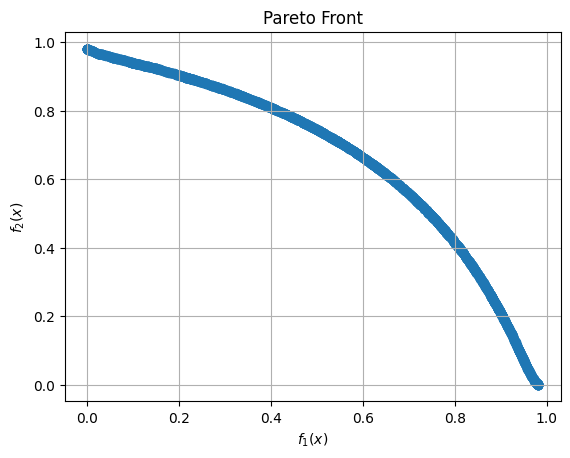

In [54]:
#@title Plotting the Pareto front
pareto_points = np.array([ind.fitness.values for ind in hof])
plt.scatter(pareto_points[:, 0], pareto_points[:, 1])
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.title("Pareto Front")
plt.grid(True)
plt.show()

### Solution without libraries
Custom implementation with NSGA II algorithm solution


In [55]:
# @title def logic

def function1(x):
    return 1 - np.exp(-np.sum((x - 1 / np.sqrt(x.shape[1])) ** 2, axis=1))

def function2(x):
    return 1 - np.exp(-np.sum((x + 1 / np.sqrt(x.shape[1])) ** 2, axis=1))

class MultiObjectiveOptimization():
    """
    This class is designed to handle multiple optimization constraints that need to be minimized.
    Parameters:
        d: The dimensionality of the input vector required by the constraint functions.
        lower: A numpy array (mx1) specifying the minimum values for the m constraints. Defaults to -1.
        upper: A numpy array (mx1) specifying the maximum values for the m constraints. Defaults to 1.
        *args: The constraint functions as Python functions, capable of processing (Nxd) numpy arrays.
    Example of use: MultiObjectiveOptimization(constraint1, constraint2, constraint3, ...)
    """
    def __init__(self, *args, dimension=None, lower_bounds=None, upper_bounds=None):
        if dimension is None:
            print("The 'd' parameter is required but not provided.")
            sys.exit(-1)
        self.dimension = dimension
        self.constraint_count = len(args)
        if self.constraint_count < 1:
            print("Please provide at least one constraint function.")
            sys.exit(-1)
        self.constraints = list(args)
        self.lower_bounds = lower_bounds if lower_bounds is not None else -np.ones((1, self.dimension))
        self.upper_bounds = upper_bounds if upper_bounds is not None else np.ones((1, self.dimension))

    def evaluate(self, x):
        """
        Applies the constraint functions to a set of input vectors.
        Parameters:
            x: A numpy matrix (N, m) where N is the number of vectors and m is the number of constraints.
        Returns:
            A numpy array (N, m) containing the results of the constraint evaluations.
        """
        vector_count = x.shape[0]
        results = np.empty((vector_count, self.constraint_count))
        for i in range(self.constraint_count):
            results[:, i] = np.squeeze(self.constraints[i](x))
        return results

class NSGA2Optimizer():
    """
    This class implements the NSGA II (Non-dominated Sorting Genetic Algorithm II) optimization process.
    """
    def __init__(self, optimization_problem, population_size=100, mutation_probability=1.0, crossover_probability=1.0, num_iterations=100, max_evaluations=100*500, initial_population=None):
        """
        Initializes the optimizer with the given parameters.
        Parameters:
            optimization_problem: An instance of a multi-objective optimization problem.
            population_size: The number of individuals in the population for each generation.
            mutation_probability: The probability that a mutation will occur (between 0 and 1).
            crossover_probability: The probability of performing a crossover operation (between 0 and 1).
            num_iterations: The maximum number of iterations to perform.
            max_evaluations: The maximum number of evaluations to perform (default is 500 times the population size).
            initial_population: An (Nxd) numpy array representing the initial population. Randomly initialized if None.
        """
        self.population_size = population_size
        self.mutation_rate = mutation_probability
        self.crossover_rate = crossover_probability
        self.num_iterations = num_iterations
        self.max_evaluations = max_evaluations
        self.problem = optimization_problem
        if initial_population is not None and initial_population.shape[1] == self.problem.dimension:
            self.population = [initial_population, self.problem.evaluate(initial_population)]
        else:
            if initial_population is not None:
                print("Incorrect dimensions for initial population. Generating a random population...")
            random_population = np.random.random((self.population_size, self.problem.dimension)) * (self.problem.upper_bounds - self.problem.lower_bounds) + self.problem.lower_bounds
            self.population = [random_population, self.problem.evaluate(random_population)]


    def sort_by_non_dominance(self, sort_limit=None):
        costs, population_size, sort_limit = self._initialize_sorting_variables(sort_limit)
        sorted_indices = np.argsort(costs[:, 0])
        sorted_costs = costs[sorted_indices, :]
        front_ranks = np.full(population_size, np.inf)
        current_front = 0

        while np.sum(front_ranks < np.inf) < sort_limit:
            current_front += 1
            for i in range(population_size):
                if front_ranks[sorted_indices[i]] == np.inf:
                    if not self._is_dominated(i, current_front, sorted_indices, front_ranks, sorted_costs):
                        front_ranks[sorted_indices[i]] = current_front

        return front_ranks, current_front


    def _initialize_sorting_variables(self, sort_limit):
        costs = self.population[1]
        population_size = costs.shape[0]
        if sort_limit is None:
            sort_limit = population_size
        return costs, population_size, sort_limit


    def _is_dominated(self, current_index, current_front, sorted_indices, front_ranks, sorted_costs):
        for j in range(current_index):
            if front_ranks[sorted_indices[j]] == current_front:
                if all(sorted_costs[current_index, :] >= sorted_costs[j, :]):
                    return True
        return False


    def calculate_crowding_distances(self, front_identifiers):
        total_individuals = self.population[0].shape[0]
        crowding_distances = np.zeros(total_individuals)
        unique_fronts = self._get_unique_fronts(front_identifiers)

        for front_number in unique_fronts:
            self._process_front(front_number, front_identifiers, crowding_distances)

        return crowding_distances


    def _get_unique_fronts(self, front_identifiers):
        unique_fronts = np.unique(front_identifiers)
        # Exclude the 'inf' value which is used as a placeholder for unassigned individuals
        return unique_fronts[unique_fronts != np.inf]


    def _process_front(self, front_number, front_identifiers, crowding_distances):
        members_of_front = np.where(front_identifiers == front_number)[0]
        solution_costs = self.population[1][members_of_front, :]

        for constraint_index in range(solution_costs.shape[1]):
            self._calculate_distances_for_front_members(constraint_index, members_of_front, solution_costs, crowding_distances)


    def _calculate_distances_for_front_members(self, constraint_index, members_of_front, solution_costs, crowding_distances):
        sorted_indices = np.argsort(solution_costs[:, constraint_index])
        # Assign infinite distance to the boundary solutions
        crowding_distances[members_of_front[sorted_indices[0]]] = np.inf
        crowding_distances[members_of_front[sorted_indices[-1]]] = np.inf

        # Calculate distances for interior points
        for j in range(1, len(members_of_front) - 1):
            prev_cost = solution_costs[sorted_indices[j - 1], constraint_index]
            next_cost = solution_costs[sorted_indices[j + 1], constraint_index]
            distance = (next_cost - prev_cost) / (np.max(solution_costs[:, constraint_index]) - np.min(solution_costs[:, constraint_index]))
            crowding_distances[members_of_front[sorted_indices[j]]] += distance


    def conduct_tournament_selection(self, fitness_values, competitors_per_tournament=2):
        """
        Executes a tournament selection process, considering crowded comparison.
        Parameters:
            fitness_values: A matrix of fitness values for the population, where higher values indicate better fitness.
            competitors_per_tournament: The number of competitors in each tournament.
        Returns:
            winners_indices: Indices of the individuals who won their respective tournaments.
        """
        total_population = len(fitness_values)
        selection_pool = np.random.randint(total_population, size=self.population_size)
        competitors_indices = np.random.randint(total_population, size=(self.population_size, competitors_per_tournament))

        for i in range(self.population_size):
            for j in range(competitors_per_tournament):
                for criteria in range(fitness_values.shape[1]):
                    if fitness_values[competitors_indices[i, j], criteria] < fitness_values[selection_pool[i], criteria]:
                        selection_pool[i] = competitors_indices[i, j]
                        break
        return selection_pool


    def generate_offspring(self, parents, boundary=None):
        '''Generates offspring from parents via crossover and mutation.'''
        dis_c, dis_m = 20, 20  # Distribution indexes for crossover and mutation
        parents = self._prepare_parents(parents)
        n, d = parents.shape

        # Crossover
        offspring = self._crossover(parents[:n//2, :], parents[n//2:, :], dis_c, d)

        # Mutation
        offspring = self._mutation(offspring, dis_m, d, boundary)

        # Ensure offspring are within bounds
        offspring = self._clip_offspring_to_bounds(offspring, boundary)
        return offspring


    def _prepare_parents(self, parents):
        '''Ensures parents array is even to form pairs for crossover.'''
        return parents[:(len(parents)//2)*2, :]


    def _crossover(self, parent_1, parent_2, dis_c, d):
        '''Performs crossover operation on parents to produce offspring.'''
        beta = self._calculate_beta(n=len(parent_1), d=d, dis_c=dis_c)
        offspring = np.vstack(((parent_1 + parent_2) / 2 + beta * (parent_1 - parent_2) / 2,
                              (parent_1 + parent_2) / 2 - beta * (parent_1 - parent_2) / 2))
        return offspring


    def _calculate_beta(self, n, d, dis_c):
        '''Calculates beta value for crossover based on distribution index.'''
        mu = np.random.random((n, d))
        beta = np.empty((n, d))
        beta[mu <= 0.5] = np.power(2 * mu[mu <= 0.5], 1 / (dis_c + 1))
        beta[mu > 0.5] = np.power(2 * mu[mu > 0.5], -1 / (dis_c + 1))
        beta = beta * ((-1)**np.random.randint(2, size=(n, d)))
        beta[np.random.random((n, d)) < 0.5] = 1
        beta[np.tile(np.random.random((n, 1)) > self.crossover_rate, (1, d))] = 1
        return beta


    def _mutation(self, offspring, dis_m, d, boundary):
        '''Applies mutation to the offspring.'''
        site = np.random.random(offspring.shape) < self.mutation_rate / d
        mu = np.random.random(offspring.shape)
        if boundary is None:
            lower, upper = np.tile(self.problem.lower_bounds, (len(offspring), 1)), np.tile(self.problem.upper_bounds, (len(offspring), 1))
        else:
            lower, upper = boundary
        offspring = self._mutate_offspring(offspring, lower, upper, site, mu, dis_m)
        return offspring


    def _clip_offspring_to_bounds(self, offspring, boundary):
        '''Clips the offspring values to stay within the given boundaries.'''
        if boundary is None:
            lower, upper = self.problem.lower_bounds, self.problem.upper_bounds
        else:
            lower, upper = boundary
        offspring = np.maximum(np.minimum(offspring, upper), lower)
        return offspring


    def _mutate_offspring(self, offspring, lower, upper, mutation_sites, mutation_probabilities, dis_m):
        '''Applies mutation to the offspring based on the given mutation sites and probabilities.'''
        # Mutation for the sites where mutation is applied and probability is less than 0.5
        temp = mutation_sites & (mutation_probabilities <= 0.5)
        norm = (offspring[temp] - lower[temp]) / (upper[temp] - lower[temp])
        delta = (np.power(2. * mutation_probabilities[temp] + (1. - 2. * mutation_probabilities[temp]) * np.power(1. - norm, dis_m + 1.), 1. / (dis_m + 1)) - 1.)
        offspring[temp] += (upper[temp] - lower[temp]) * delta

        # Mutation for the sites where mutation is applied and probability is greater than 0.5
        temp = mutation_sites & ~temp
        norm = (upper[temp] - offspring[temp]) / (upper[temp] - lower[temp])
        delta = (1. - np.power(2. * (1. - mutation_probabilities[temp]) + 2. * (mutation_probabilities[temp] - 0.5) * np.power(1. - norm, dis_m + 1.), 1. / (dis_m + 1)))
        offspring[temp] += (upper[temp] - lower[temp]) * delta

        return offspring


    def execute_environmental_selection(self):
        '''Determines the next generation by employing non-dominance sorting and crowding distance evaluation.'''
        sorted_front_ids, highest_front = self.sort_by_non_dominance(sort_limit=self.population_size)
        selection_flags = np.zeros_like(sorted_front_ids, dtype=bool)
        selection_flags[sorted_front_ids < highest_front] = True
        crowding_distances = self.calculate_crowding_distances(sorted_front_ids)
        border_individuals = np.where(sorted_front_ids == highest_front)[0]
        ordered_by_crowding = np.argsort(-crowding_distances[border_individuals])
        required_individuals = ordered_by_crowding[:self.population_size - int(np.sum(selection_flags))]
        selection_flags[border_individuals[required_individuals]] = True
        chosen_indices = np.where(selection_flags)[0]
        self.population = [self.population[0][chosen_indices, :], self.population[1][chosen_indices, :]]
        return sorted_front_ids[chosen_indices], crowding_distances[chosen_indices], chosen_indices


    def execute_algorithm(self):
        '''Runs the optimization process until the evaluation or iteration limits are reached.'''
        current_front_ids, highest_front = self.sort_by_non_dominance()
        current_crowding_distances = self.calculate_crowding_distances(current_front_ids)

        remaining_evaluations, current_iteration = self.max_evaluations, 0
        while remaining_evaluations > 0 and current_iteration < self.num_iterations:
            combined_fitness = np.vstack((current_front_ids, current_crowding_distances)).T
            selection_pool = self.conduct_tournament_selection(combined_fitness)
            parents = [self.population[0][selection_pool], self.population[1][selection_pool]]
            new_offspring = self.generate_offspring(parents[0])
            new_offspring_costs = self.problem.evaluate(new_offspring)
            self.population = [np.vstack([self.population[0], new_offspring]), np.vstack([self.population[1], new_offspring_costs])]
            current_front_ids, current_crowding_distances, _ = self.execute_environmental_selection()
            remaining_evaluations -= self.population_size
            current_iteration += 1

        print(f"Number of iterations completed: {current_iteration}, Evaluations used: {self.max_evaluations - remaining_evaluations}")
        return self.population


    def visualize(self):
        _ = self.execute_algorithm()
        # Retrieve population costs and identify the non-dominated front.
        pop_cost = self.population[1]
        front_ids, _ = self.sort_by_non_dominance()
        non_dominated = pop_cost[front_ids == 1, :]

        # Plotting for two-dimensional data.
        fig, ax = plt.subplots()
        ax.scatter(non_dominated[:, 0], non_dominated[:, 1], c='blue', marker='o', edgecolor='k', label='Non-dominated solutions')

        # Enhancing the visualization
        ax.set_title('Pareto Front')
        ax.set_xlabel('Objective 1')
        ax.set_ylabel('Objective 2')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

        plt.tight_layout()  # Adjust the layout to make room for the elements
        plt.show()
        return ax

In [56]:
# @title result

# Initialize the multi-objective optimization problem with the specified objective functions,
# dimension, and variable bounds
problem = MultiObjectiveOptimization(function1, function2, dimension=3, lower_bounds=np.full((1, 3), -4), upper_bounds=np.full((1, 3), 4))

# Initialize the NSGA-II algorithm with the optimization problem, population size, and number of iterations
nsgaii = NSGA2Optimizer(problem, population_size=50, num_iterations=100)


### Visualization

Number of iterations completed: 100, Evaluations used: 5000


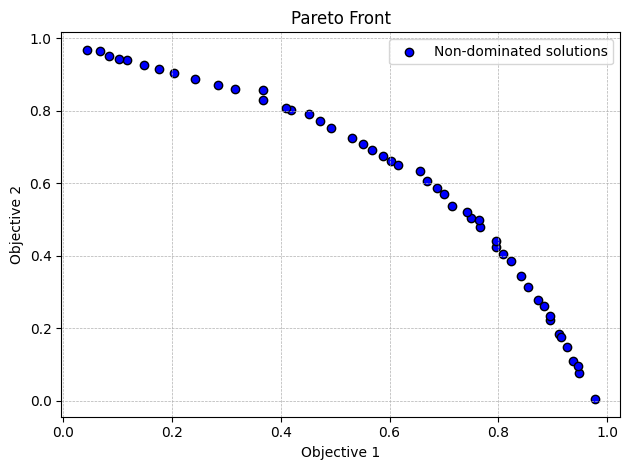

In [57]:
#@title Plotting the Pareto front
ax = nsgaii.visualize()
ax.set_title('Pareto Front')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')
plt.show()

Number of iterations completed: 100, Evaluations used: 10000


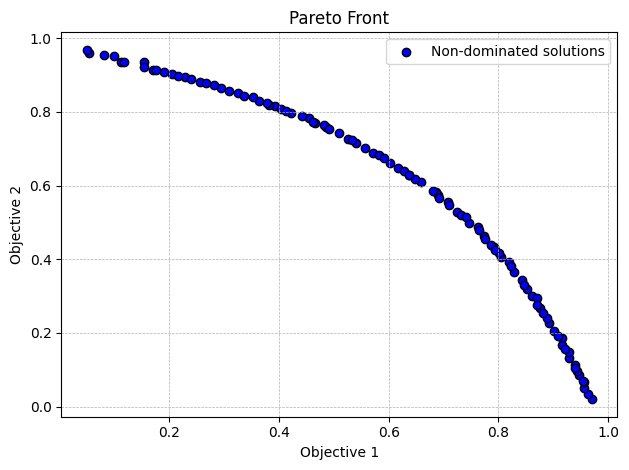

In [58]:
# @title Plotting the Pareto front adapted for Specified Lower and Upper Bounds

# New lower and upper bounds
lb = np.array([-4, -4, -4])
ub = np.array([4, 4, 4])

# Initialize problem with specified functions, dimension, and new bounds
problem = MultiObjectiveOptimization(function1, function2, dimension=3, lower_bounds=lb, upper_bounds=ub)

# Initialize and run NSGA-II as before
nsgaii = NSGA2Optimizer(problem, population_size=100, num_iterations=100)

# Visualize the results similarly
ax = nsgaii.visualize()
ax.set_title('Pareto Front with New Bounds')
ax.set_xlabel('f1(x)')
ax.set_ylabel('f2(x)')
plt.show()

In [59]:
# @title Scatter Plot of f_1(z) vs f_2(z)

# Define the function
f_1 = lambda x: 1 - np.exp(-np.sum((x - np.sqrt(1/len(x)))**2))
f_2 = lambda x: 1 - np.exp(-np.sum((x + np.sqrt(1/len(x)))**2))

# Generate values for z
z_values = np.random.rand(10000,2)*8-4

# Generate corresponding values for f_1(z) and f_2(z)
f_1_values = [f_1(z) for z in z_values]  # assuming n=1
f_2_values = [f_2(z) for z in z_values]  # assuming n=1

# Create a scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=f_1_values, y=f_2_values, mode='markers', marker=dict(size=8)))

# Set axis labels and plot title
fig.update_layout(
    title='Scatter Plot of f_1(z) vs f_2(z)',
    xaxis=dict(title='f_1(z)'),
    yaxis=dict(title='f_2(z)')
)

# Show the plot
fig.show()

In [60]:
# @title Functions for n=2

x = np.linspace(-4,4, 100)
z  = [(f_1(np.array([i,j])),i,j,'f1') for i,j in product(x,x)]
z += [(f_2(np.array([i,j])),i,j,'f2') for i,j in product(x,x)]
df = pd.DataFrame(z)
px.scatter_3d(df,1,2,0, color=3, title='Functions for n=2')

### Comparative Analysis of NSGA-II Implementations

##### Library Implementation Results
- **Continuity**: The Pareto front is smooth, indicating effective exploration of the solution space.
- **Density Indication**: The shading may represent higher solution density in certain regions.
- **Coverage**: There appears to be good coverage across the trade-off between objectives, which is essential for decision-making.

##### Custom Code Implementation Results
- **Discrete Points**: The Pareto front is composed of discrete, well-distributed points, showing the algorithm's capability in finding diverse non-dominated solutions.
- **Diversity**: The even spread of points suggests that the algorithm maintains diversity, exploring both extremes of the trade-off curve.

##### Observations from Comparative Analysis
- **Visualization Style**: The library gives a 'filled' appearance to the Pareto front, potentially indicating a higher density of solutions, while the custom implementation presents individual solutions more clearly.
- **Solution Mapping**: Both implementations map a similar Pareto front shape, effectively solving the optimization problem.
- **Aesthetics and Usability**: The second image is clearer for individual solution analysis, while the first might provide more insight into solution concentration but with less clarity on individual points.

##### Conclusion
Both implementations appear to successfully identify the Pareto front, indicating effective multi-objective optimization. Preferences between implementations may depend on desired visualization style, granularity of results, and robustness of the optimization process.

To further this analysis, consider utilizing quantitative metrics such as hypervolume, spacing, and spread. Additionally, assessing the consistency of results across multiple iterations can offer deeper insights into the performance and reliability of each implementation.

## Task 3

Due to the upcoming holiday (8th of March), flower market decided to optimize its delivery (= minimize delivery costs). At the begging of the day couriers pick up flowers from the flower market and deliver them to clients. Each client needs only certain number of flowers and each courier can carry only certain number of flowers. Couriers are paid for the distance travelled.
All required data is in the attached file.

Make sure to write your mathematical model for the given problem (yes, using formu- las). Then code it in python and solve.

## Math model
### Parameters:

$c_{ij}$ - distance from client $i$ to client $j$

$Q_v: $ the load capacity of the courier $v$

$S_v: $ Salary of the courier $v$ per distance

$q_i$ : demand of the client $i$

$y_{vi}$ - amount of flowers delivered by courier v to client $i$

$x_{vij}$ - boolean flag indicates if courier v goes from client i to client $j$

### Objective function:
$$
\min \sum_{i = 1}\sum_{j = 1}\sum_{v = 1} S_vc_{ij}x_{vij}
$$

### Constraints:

-  Each customer visited strictly once.
$$
\sum_{i = 1}\sum_{v = 1} x_{vij} = \sum_{i = 1}\sum_{v = 1} x_{vji}=1, \ \ \ j = 1,...,n
$$

- If any arc variable indexed by vehicle $k$ goes into one node $i$ or out of it, the demand $q$ of this node is assigned to courier $k$.
$$
\sum_{i = 0} x_{viz} = \sum_{j = 0} x_{vzj} \ \ z = 0,...,n, \ v = 0,...,m
$$

- Strictly no subtours.
$$
y_{vi} \leq q_i \sum_{j = 1} x_{vij} \ \ \ i = 1, ..., n, \ v = 0, ..., m
$$

-  The total amount of cargo delivered to the client have to fully satisfy client's demand.
$$
\sum_{v = 0} y_{vi} = q_i, \ \ \ i = 1, ..., n
$$

- The total amount of cargo delivered by the courier have to be less of equal to he's load capacity.
$$
\sum_{i = 1} y_{vi} \leq Q_v, \ \ \ v = 0, ..., m
$$

- Couriers start at the depot and arrive at the depot.
$$
\sum_{v =1} \sum_{i =1} x_{i0v} = \sum_{v =1} \sum_{i =1} x_{0iv} = |V|
$$

In [124]:
# @title Solution for version 1 (max  grade 8)

distance_matrix = np.array([
      [0, 5.48, 7.76, 6.96, 5.82, 2.74, 5.02, 1.94, 3.08, 1.94, 5.36, 5.02, 3.88, 3.54, 4.68, 7.76, 6.62],
      [5.48, 0, 6.84, 3.08, 1.94, 5.02, 7.30, 3.54, 6.96, 7.42, 10.84, 5.94, 4.80, 6.74, 10.16, 8.68, 12.10],
      [7.76, 6.84, 0, 9.92, 8.78, 5.02, 2.74, 8.10, 4.68, 7.42, 4.00, 12.78, 11.64, 11.30, 7.88, 15.52, 7.54],
      [6.96, 3.08, 9.92, 0, 1.14, 6.50, 8.78, 5.02, 8.44, 8.90, 12.32, 5.14, 6.28, 8.22, 11.64, 5.60, 13.58],
      [5.82, 1.94, 8.78, 1.14, 0, 5.36, 7.64, 3.88, 7.30, 7.76, 11.18, 4.00, 5.14, 7.08, 10.50, 6.74, 12.44],
      [2.74, 5.02, 5.02, 6.50, 5.36, 0, 2.28, 3.08, 1.94, 2.40, 5.82, 7.76, 6.62, 6.28, 5.14, 10.50, 7.08],
      [5.02, 7.30, 2.74, 8.78, 7.64, 2.28, 0, 5.36, 1.94, 4.68, 3.54, 10.04, 8.90, 8.56, 5.14, 12.78, 4.80],
      [1.94, 3.54, 8.10, 5.02, 3.88, 3.08, 5.36, 0, 3.42, 3.88, 7.30, 4.68, 3.54, 3.20, 6.62, 7.42, 8.56],
      [3.08, 6.96, 4.68, 8.44, 7.30, 1.94, 1.94, 3.42, 0, 2.74, 3.88, 8.10, 6.96, 6.62, 3.20, 10.84, 5.14],
      [1.94, 7.42, 7.42, 8.90, 7.76, 2.40, 4.68, 3.88, 2.74, 0, 3.42, 5.36, 4.22, 3.88, 2.74, 8.10, 4.68],
      [5.36, 10.84, 4.00, 12.32, 11.18, 5.82, 3.54, 7.30, 3.88, 3.42, 0, 8.78, 7.64, 7.30, 3.88, 11.52, 3.54],
      [5.02, 5.94, 12.78, 5.14, 4.00, 7.76, 10.04, 4.68, 8.10, 5.36, 8.78, 0, 1.14, 3.08, 6.50, 2.74, 8.44],
      [3.88, 4.80, 11.64, 6.28, 5.14, 6.62, 8.90, 3.54, 6.96, 4.22, 7.64, 1.14, 0, 1.94, 5.36, 3.88, 7.30],
      [3.54, 6.74, 11.30, 8.22, 7.08, 6.28, 8.56, 3.20, 6.62, 3.88, 7.30, 3.08, 1.94, 0, 3.42, 4.22, 5.36],
      [4.68, 10.16, 7.88, 11.64, 10.50, 5.14, 5.14, 6.62, 3.20, 2.74, 3.88, 6.50, 5.36, 3.42, 0, 7.64, 1.94],
      [7.76, 8.68, 15.52, 5.60, 6.74, 10.50, 12.78, 7.42, 10.84, 8.10, 11.52, 2.74, 3.88, 4.22, 7.64, 0, 7.98],
      [6.62, 12.10, 7.54, 13.58, 12.44, 7.08, 4.80, 8.56, 5.14, 4.68, 3.54, 8.44, 7.30, 5.36, 1.94, 7.98, 0]
])

flower_market_id = 0
demands = [0, 100, 100, 200, 400, 200, 400, 800, 800, 100, 200, 100, 200, 400, 400, 800, 800]
# max grade 8
num_couriers = 4
salary_per_km = 100
courier_max_load = [2500, 2000, 1000, 500]

demands = np.array(demands)
courier_max_load = np.array(courier_max_load)
salary_per_km = np.array([salary_per_km]*num_couriers)

clients = range(0, len(demands))

# Problem setup
problem = pulp.LpProblem("VRP_Flower_Delivery", pulp.LpMinimize)

# Decision Variables
# x[i, j, k] = 1 if courier i travels from client j to client k

x = pulp.LpVariable.dicts("x",
                          ((i, j, k) for i in range(len(courier_max_load)) for j in clients for k in clients if j != k),
                          cat='Binary')

y = pulp.LpVariable.dicts("y",
                          ((i, j) for i in range(len(courier_max_load)) for j in clients[1:]),
                          cat='Integer')

# Objective Function: Minimize total distance traveled considering salary
problem += pulp.lpSum([x[(i, j, k)] * distance_matrix[j][k] * salary_per_km[i]
                       for i in range(len(courier_max_load))
                       for j in clients for k in clients if j != k]), "Total_Cost"

# Constraints

# Constraint: Each client is visited exactly once
for k in clients[1:]:
    problem += pulp.lpSum([x[(v, j, k)] for v in range(len(courier_max_load)) for j in clients if j != k]) == 1

# Constraint: Flow conservation
for z in clients[1:]:
    for v in range(len(courier_max_load)):
        problem += (pulp.lpSum(x[(v, i, z)] for i in clients if i != z) - pulp.lpSum(x[(v, z, j)] for j in clients if j != z)) == 0

# Constraint: Demand satisfaction
for v in range(len(courier_max_load)):
    for i in clients[1:]:
        problem += pulp.lpSum([x[(v, i, j)] * demands[i] for j in clients if j != i]) >= y[(v, i)]

# Constraint: Demand fulfillment
for i in clients[1:]:
    problem += pulp.lpSum([y[(v, i)] for v in range(len(courier_max_load))]) == demands[i]

# Constraint: Capacity constraint for each courier
for v in range(len(courier_max_load)):
    problem += pulp.lpSum([y[(v, i)] for i in clients[1:]]) <= courier_max_load[v]

# Constraint: Each vehicle leaves and returns to the depot
for v in range(len(courier_max_load)):
    # Leaving the depot
    problem += pulp.lpSum(x[(v, 0, j)] for j in clients if j != 0) == 1
    # Returning to the depot
    problem += pulp.lpSum(x[(v, i, 0)] for i in clients if i != 0) == 1

# Add variables for subtour elimination
u = {i: pulp.LpVariable(f"u_{i}", lowBound=0, cat='Continuous') for i in clients[1:]}

# Constraint: Subtour elimination
for v in range(len(courier_max_load)):
    for i in clients[1:]:
        for j in clients[1:]:
            if i != j:
                problem += u[i] - u[j] + (len(clients) - 1) * x[(v, i, j)] <= len(clients) - 2

problem += pulp.lpSum([x[(v, i, 0)] for v in range(len(courier_max_load)) for i in clients[1:]]) == pulp.lpSum([x[(v, 0, j)] for v in range(len(courier_max_load)) for j in clients[1:]]) and pulp.lpSum([x[(v, i, 0)] for v in range(len(courier_max_load)) for i in clients[1:]]) == len(courier_max_load)

# Solve the problem
problem.solve()

# Results
print("Status:", pulp.LpStatus[problem.status])
for v in problem.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

print("Total Delivery Cost: $", pulp.value(problem.objective))

Status: Optimal
u_1 = 4.0
u_10 = 2.0
u_13 = 1.0
u_14 = 4.0
u_15 = 1.0
u_16 = 3.0
u_2 = 1.0
u_3 = 2.0
u_4 = 3.0
u_7 = 5.0
u_8 = 1.0
u_9 = 5.0
x_(0,_0,_12) = 1.0
x_(0,_1,_7) = 1.0
x_(0,_12,_15) = 1.0
x_(0,_15,_3) = 1.0
x_(0,_3,_4) = 1.0
x_(0,_4,_1) = 1.0
x_(0,_7,_0) = 1.0
x_(1,_0,_6) = 1.0
x_(1,_10,_16) = 1.0
x_(1,_14,_9) = 1.0
x_(1,_16,_14) = 1.0
x_(1,_2,_10) = 1.0
x_(1,_6,_2) = 1.0
x_(1,_9,_0) = 1.0
x_(2,_0,_5) = 1.0
x_(2,_5,_8) = 1.0
x_(2,_8,_0) = 1.0
x_(3,_0,_11) = 1.0
x_(3,_11,_13) = 1.0
x_(3,_13,_0) = 1.0
y_(0,_1) = 100.0
y_(0,_12) = 200.0
y_(0,_15) = 800.0
y_(0,_3) = 200.0
y_(0,_4) = 400.0
y_(0,_7) = 800.0
y_(1,_10) = 200.0
y_(1,_14) = 400.0
y_(1,_16) = 800.0
y_(1,_2) = 100.0
y_(1,_6) = 400.0
y_(1,_9) = 100.0
y_(2,_5) = 200.0
y_(2,_8) = 800.0
y_(3,_11) = 100.0
y_(3,_13) = 400.0
Total Delivery Cost: $ 6324.0


In [125]:
# @title def points2paths(points)
def convert_to_adjacency_matrix(points):
    # Find the maximum x and y coordinates to determine the size of the matrix
    max_x = max(point[0] for point in points)
    max_y = max(point[1] for point in points)

    # Initialize an empty adjacency matrix with all zeros
    adjacency_matrix = [[0] * (max_y + 1) for _ in range(max_x + 1)]

    # Mark the adjacency matrix based on the points
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        adjacency_matrix[x1][y1] = 1
        adjacency_matrix[x2][y2] = 1

    return adjacency_matrix

def find_cycles(adj_matrix):
    def dfs(node, start_node, visited, path):
        # Mark the current node as visited
        visited[node] = True
        path.append(node)

        # Check if we have a cycle
        if node == start_node and len(path) > 2:
            cycles.append(path[:])
        else:
            # Continue DFS for adjacent nodes
            for i, connected in enumerate(adj_matrix[node]):
                if connected and (not visited[i] or i == start_node):
                    dfs(i, start_node, visited[:], path[:])

    cycles = []
    num_nodes = len(adj_matrix)

    # Perform DFS from each node to find cycles
    for i in range(num_nodes):
        visited = [False] * num_nodes
        dfs(i, i, visited, [])

    return cycles

def find_non_isomorphic_cycles(cycles):
    """
    Find non-isomorphic cycles from a list of cycles.
    """
    non_isomorphic_cycles = dict()
    for cycle in cycles:
        non_isomorphic_cycles[tuple(sorted(set(cycle)))] = cycle
    return non_isomorphic_cycles

def points2paths(points):
    adjacency_matrix = convert_to_adjacency_matrix(points)
    cycles = find_cycles(adjacency_matrix)
    cycles = find_non_isomorphic_cycles(cycles)
    return list(cycles.values())

couriers = [eval(v.name.replace('_','').replace('x',''))  for v in problem.variables() if v.varValue==1 and 'u' not in v.name]
couriers_dict = {i: list() for i in range(4)}
for i,j,k in couriers:
    couriers_dict[i] += [(j,k)]
couriers_dict = {i:points2paths(j) for i,j in couriers_dict.items()}
ans = []
for i in couriers_dict.values():
    for j in i:
        ans += [j]
couriers_dict

{0: [[15, 3, 4, 1, 7, 0, 12, 15]],
 1: [[16, 14, 9, 0, 6, 2, 10, 16]],
 2: [[8, 0, 5, 8]],
 3: [[13, 0, 11, 13]]}

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


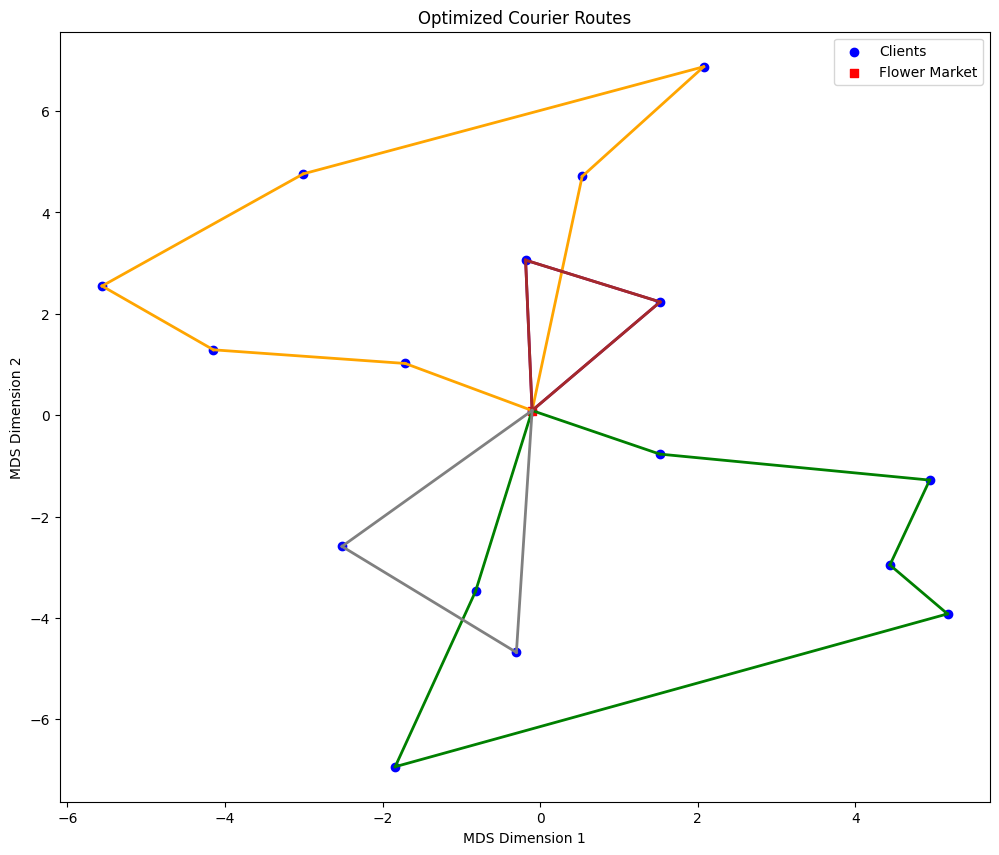

In [113]:
# @title Visualization
courier_paths = ans

# Преобразование матрицы расстояний в координаты с использованием MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coordinates_mds = mds.fit_transform(distance_matrix)

# Инициализация графика
plt.figure(figsize=(12, 10))

# Отображение точек для всех клиентов и рынка цветов
plt.scatter(coordinates_mds[:, 0], coordinates_mds[:, 1], c='blue', label='Clients')  # Клиенты
plt.scatter(coordinates_mds[0, 0], coordinates_mds[0, 1], c='red', marker='s', label='Flower Market')  # Рынок

# Визуализация маршрутов курьеров
# Замените 'courier_paths' на ваши реальные маршруты
courier_colors = ['green', 'orange', 'purple', 'brown']  # Цвета для различных курьеров
courier_colors += ['gray']*(len(courier_paths)-len(courier_colors))
for path, color in zip(courier_paths, courier_colors):
    for i in range(len(path)-1):
        plt.plot([coordinates_mds[path[i], 0], coordinates_mds[path[i+1], 0]],
                 [coordinates_mds[path[i], 1], coordinates_mds[path[i+1], 1]],
                 c=color, linewidth=2)

# Добавление легенды и заголовка
plt.title('Optimized Courier Routes')
plt.legend()
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

In [121]:
# @title Solution for version 2 (max  grade 10)

distance_matrix = np.array([
      [0, 5.48, 7.76, 6.96, 5.82, 2.74, 5.02, 1.94, 3.08, 1.94, 5.36, 5.02, 3.88, 3.54, 4.68, 7.76, 6.62],
      [5.48, 0, 6.84, 3.08, 1.94, 5.02, 7.30, 3.54, 6.96, 7.42, 10.84, 5.94, 4.80, 6.74, 10.16, 8.68, 12.10],
      [7.76, 6.84, 0, 9.92, 8.78, 5.02, 2.74, 8.10, 4.68, 7.42, 4.00, 12.78, 11.64, 11.30, 7.88, 15.52, 7.54],
      [6.96, 3.08, 9.92, 0, 1.14, 6.50, 8.78, 5.02, 8.44, 8.90, 12.32, 5.14, 6.28, 8.22, 11.64, 5.60, 13.58],
      [5.82, 1.94, 8.78, 1.14, 0, 5.36, 7.64, 3.88, 7.30, 7.76, 11.18, 4.00, 5.14, 7.08, 10.50, 6.74, 12.44],
      [2.74, 5.02, 5.02, 6.50, 5.36, 0, 2.28, 3.08, 1.94, 2.40, 5.82, 7.76, 6.62, 6.28, 5.14, 10.50, 7.08],
      [5.02, 7.30, 2.74, 8.78, 7.64, 2.28, 0, 5.36, 1.94, 4.68, 3.54, 10.04, 8.90, 8.56, 5.14, 12.78, 4.80],
      [1.94, 3.54, 8.10, 5.02, 3.88, 3.08, 5.36, 0, 3.42, 3.88, 7.30, 4.68, 3.54, 3.20, 6.62, 7.42, 8.56],
      [3.08, 6.96, 4.68, 8.44, 7.30, 1.94, 1.94, 3.42, 0, 2.74, 3.88, 8.10, 6.96, 6.62, 3.20, 10.84, 5.14],
      [1.94, 7.42, 7.42, 8.90, 7.76, 2.40, 4.68, 3.88, 2.74, 0, 3.42, 5.36, 4.22, 3.88, 2.74, 8.10, 4.68],
      [5.36, 10.84, 4.00, 12.32, 11.18, 5.82, 3.54, 7.30, 3.88, 3.42, 0, 8.78, 7.64, 7.30, 3.88, 11.52, 3.54],
      [5.02, 5.94, 12.78, 5.14, 4.00, 7.76, 10.04, 4.68, 8.10, 5.36, 8.78, 0, 1.14, 3.08, 6.50, 2.74, 8.44],
      [3.88, 4.80, 11.64, 6.28, 5.14, 6.62, 8.90, 3.54, 6.96, 4.22, 7.64, 1.14, 0, 1.94, 5.36, 3.88, 7.30],
      [3.54, 6.74, 11.30, 8.22, 7.08, 6.28, 8.56, 3.20, 6.62, 3.88, 7.30, 3.08, 1.94, 0, 3.42, 4.22, 5.36],
      [4.68, 10.16, 7.88, 11.64, 10.50, 5.14, 5.14, 6.62, 3.20, 2.74, 3.88, 6.50, 5.36, 3.42, 0, 7.64, 1.94],
      [7.76, 8.68, 15.52, 5.60, 6.74, 10.50, 12.78, 7.42, 10.84, 8.10, 11.52, 2.74, 3.88, 4.22, 7.64, 0, 7.98],
      [6.62, 12.10, 7.54, 13.58, 12.44, 7.08, 4.80, 8.56, 5.14, 4.68, 3.54, 8.44, 7.30, 5.36, 1.94, 7.98, 0]
])

flower_market_id = 0
demands = [0, 100, 100, 200, 400, 200, 400, 800, 800, 100, 200, 100, 200, 400, 400, 800, 800]
# max grade 10
num_couriers = 4
salary_per_km = [100, 80, 80, 60]
courier_max_load = [2500, 1500, 1500, 500]

demands = np.array(demands)
courier_max_load = np.array(courier_max_load)
salary_per_km = np.array(salary_per_km)

clients = range(0, len(demands))

# Problem setup
problem = pulp.LpProblem("VRP_Flower_Delivery", pulp.LpMinimize)

# Decision Variables
# x[i, j, k] = 1 if courier i travels from client j to client k
x = pulp.LpVariable.dicts("x",
                          ((i, j, k) for i in range(len(courier_max_load)) for j in clients for k in clients if j != k),
                          cat='Binary')
y = pulp.LpVariable.dicts("y",
                          ((i, j) for i in range(len(courier_max_load)) for j in clients[1:]),
                          cat='Integer')

# Objective Function: Minimize total distance traveled considering salary
problem += pulp.lpSum([x[(i, j, k)] * distance_matrix[j][k] * salary_per_km[i]
                       for i in range(len(courier_max_load))
                       for j in clients for k in clients if j != k]), "Total_Cost"

# Constraints
for j in clients[1:]:
    problem += pulp.lpSum([x[(i, j, k)] for i in range(len(courier_max_load)) for k in clients if j != k]) == 1
for i in range(len(courier_max_load)):
    for j in clients[1:]:
        problem += pulp.lpSum([x[(i, h, j)] for h in clients if h != j]) == pulp.lpSum([x[(i, j, k)] for k in clients if k != j])
for i in range(len(courier_max_load)):
    problem += pulp.lpSum([demands[j] * x[(i, j, k)] for j in clients for k in clients if j != k]) <= courier_max_load[i]
for i in range(len(courier_max_load)):
    problem += pulp.lpSum([demands[j] * x[(i, j, k)] for j in clients for k in clients if j != k]) <= courier_max_load[i]
for i in range(len(courier_max_load)):
    # Ensure that every courier starts from the depot
    problem += pulp.lpSum([x[(i, 0, j)] for j in clients[1:]]) == 1
    # Ensure that every courier ends at the depot
    problem += pulp.lpSum([x[(i, j, 0)] for j in clients[1:]]) == 1


# Add variables for subtour elimination
u = {i: pulp.LpVariable(f"u_{i}", lowBound=0, cat='Continuous') for i in clients[1:]}

# Constraint: Subtour elimination
for v in range(len(courier_max_load)):
    for i in clients[1:]:
        for j in clients[1:]:
            if i != j:
                problem += u[i] - u[j] + (len(clients) - 1) * x[(v, i, j)] <= len(clients) - 2


problem += pulp.lpSum([x[(v, i, 0)] for v in range(len(courier_max_load)) for i in clients[1:]]) == pulp.lpSum([x[(v, 0, j)] for v in range(len(courier_max_load)) for j in clients[1:]])
problem += pulp.lpSum([x[(v, i, 0)] for v in range(len(courier_max_load)) for i in clients[1:]]) == len(courier_max_load)

# Solve the problem
problem.solve()

# Results
print("Status:", pulp.LpStatus[problem.status])
for v in problem.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

print("Total Delivery Cost: $", pulp.value(problem.objective))

Status: Optimal
u_1 = 1.0
u_10 = 2.0
u_11 = 1.0
u_13 = 3.0
u_14 = 3.0
u_15 = 2.0
u_16 = 2.0
u_2 = 1.0
u_3 = 2.0
u_4 = 3.0
u_6 = 1.0
u_9 = 4.0
x_(0,_0,_8) = 1.0
x_(0,_14,_9) = 1.0
x_(0,_16,_14) = 1.0
x_(0,_6,_16) = 1.0
x_(0,_8,_6) = 1.0
x_(0,_9,_0) = 1.0
x_(1,_0,_7) = 1.0
x_(1,_1,_3) = 1.0
x_(1,_3,_4) = 1.0
x_(1,_4,_0) = 1.0
x_(1,_7,_1) = 1.0
x_(2,_0,_12) = 1.0
x_(2,_11,_15) = 1.0
x_(2,_12,_11) = 1.0
x_(2,_13,_0) = 1.0
x_(2,_15,_13) = 1.0
x_(3,_0,_5) = 1.0
x_(3,_10,_0) = 1.0
x_(3,_2,_10) = 1.0
x_(3,_5,_2) = 1.0
Total Delivery Cost: $ 5154.4


In [122]:
couriers = [eval(v.name.replace('_','').replace('x',''))  for v in problem.variables() if v.varValue==1 and 'u' not in v.name]
couriers_dict = {i: list() for i in range(4)}
for i,j,k in couriers:
    couriers_dict[i] += [(j,k)]
couriers_dict = {i:points2paths(j) for i,j in couriers_dict.items()}
ans = []
for i in couriers_dict.values():
    for j in i:
        ans += [j]
couriers_dict

{0: [[16, 14, 9, 0, 8, 6, 16]],
 1: [[7, 1, 3, 4, 0, 7]],
 2: [[15, 13, 0, 12, 11, 15]],
 3: [[10, 0, 5, 2, 10]]}

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


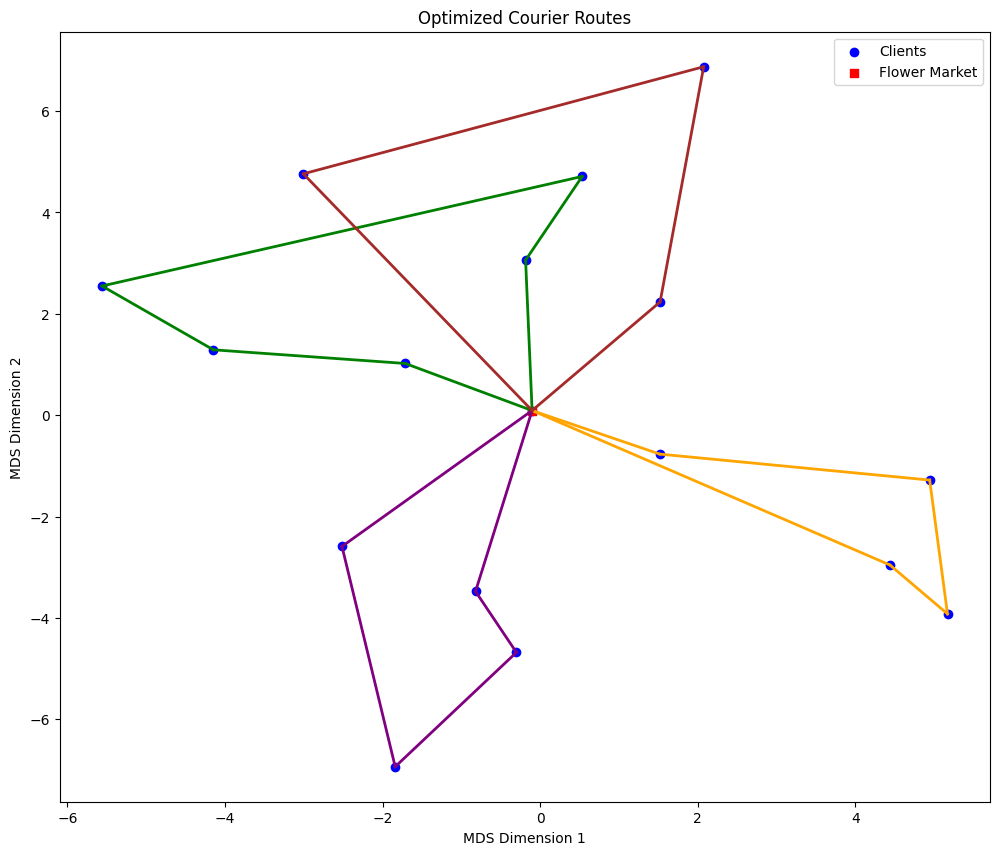

In [123]:
# @title Visualization
courier_paths = ans

# Преобразование матрицы расстояний в координаты с использованием MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coordinates_mds = mds.fit_transform(distance_matrix)

# Инициализация графика
plt.figure(figsize=(12, 10))

# Отображение точек для всех клиентов и рынка цветов
plt.scatter(coordinates_mds[:, 0], coordinates_mds[:, 1], c='blue', label='Clients')  # Клиенты
plt.scatter(coordinates_mds[0, 0], coordinates_mds[0, 1], c='red', marker='s', label='Flower Market')  # Рынок

# Визуализация маршрутов курьеров
# Замените 'courier_paths' на ваши реальные маршруты
courier_colors = ['green', 'orange', 'purple', 'brown']  # Цвета для различных курьеров
courier_colors += ['gray']*(len(courier_paths)-len(courier_colors))
for path, color in zip(courier_paths, courier_colors):
    for i in range(len(path)-1):
        plt.plot([coordinates_mds[path[i], 0], coordinates_mds[path[i+1], 0]],
                 [coordinates_mds[path[i], 1], coordinates_mds[path[i+1], 1]],
                 c=color, linewidth=2)

# Добавление легенды и заголовка
plt.title('Optimized Courier Routes')
plt.legend()
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()